# Appendix B: K-Means customer segmentation case study 

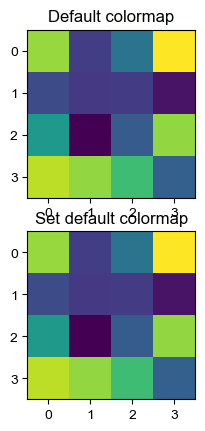

In [1]:
import os
import random
import sys
import time

import numpy as np
import pandas as pd

sys.path.append("code/.")
import matplotlib.pyplot as plt
import seaborn as sns

from plotting_functions import *
from sklearn import cluster, datasets, metrics
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
# from support_functions import *
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

#plt.style.use("seaborn")

plt.rcParams["font.size"] = 16

### What is customer segmentation? 

- Understand landscape of the market in businesses and craft targeted business or marketing strategies tailored for each group.

<img src="img/customer-segmentation.png" alt="" height="600" width="600"> 

[source](https://www.youtube.com/watch?v=zPJtDohab-g&t=134s)

Check out [this interesting talk by Malcom Gladwell](https://www.ted.com/talks/malcolm_gladwell_on_spaghetti_sauce?language=en). Humans are diverse and there is no single spaghetti sauce that would make all of them happy! 

Often it's beneficial to businesses to explore the landscape of the market and tailor their services and products offered to each group. This is called **customer segmentation**. It's usually applied when the dataset contains some of the following features. 

- **Demographic information** such as gender, age, marital status, income, education, and occupation
- **Geographical information** such as specific towns or counties or a customer's city, state, or even country of residence (in case of big global companies)
- **Psychographics** such as social class, lifestyle, and personality traits
- **Behavioral data** such as spending and consumption habits, product/service usage, and desired benefits 

### Business problem 

- Imagine that you are hired as a data scientist at a bank. They provide some data of their credit card customers to you. 
- Their goal is to develop customized marketing campaigns and they ask you to group customers based on the given information. 
- Now that you know about K-Means clustering, let's apply it to the dataset to group customers. 

### Data

- We will use the [Credit Card Dataset for clustering](https://www.kaggle.com/arjunbhasin2013/ccdata) from Kaggle.
- Download the data and save the CSV under the `data` folder. 
- I encourage you to work through this case study on your own. 

In [2]:
creditcard_df = pd.read_csv("data/CC General.csv")
creditcard_df.shape

(8950, 18)

### Information of the dataset 

We have behavioral data. 

- CUSTID: Identification of Credit Card holder
- BALANCE: Balance amount left in customer's account to make purchases
- BALANCE_FREQUENCY: How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)
- PURCHASES: Amount of purchases made from account
- ONEOFFPURCHASES: Maximum purchase amount done in one-go
- INSTALLMENTS_PURCHASES: Amount of purchase done in installment
- CASH_ADVANCE: Cash in advance given by the user
- PURCHASES_FREQUENCY: How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)
- ONEOFF_PURCHASES_FREQUENCY: How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)
- PURCHASES_INSTALLMENTS_FREQUENCY: How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)
- CASH_ADVANCE_FREQUENCY: How frequently the cash in advance being paid
- CASH_ADVANCE_TRX: Number of Transactions made with "Cash in Advance"
- PURCHASES_TRX: Number of purchase transactions made
- CREDIT_LIMIT: Limit of Credit Card for user
- PAYMENTS: Amount of Payment done by user
- MINIMUM_PAYMENTS: Minimum amount of payments made by user
- PRC_FULL_PAYMENT: Percent of full payment paid by user
- TENURE: Tenure of credit card service for user

### Preliminary EDA

In [3]:
creditcard_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

- All numeric features
- Some missing values

In [4]:
creditcard_df.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


### Practice exercises for you

1. What is the average `BALANCE` amount?
2. How often the `BALANCE_FREQUENCY` is updated on average? 
3. Obtain the row the customer who made the maximum cash advance transaction. 

<br><br><br><br>

### Mini exercises for you (Answers)

1. What is the average `BALANCE` amount? 1564.47
2. How often the `BALANCE_FREQUENCY` is updated on average? 0.877 (pretty often) 
3. Obtain the row of the customer who made the maximum cash advance transaction. 

In [5]:
# Answer 3.
max_cash_advance = creditcard_df["CASH_ADVANCE"].max()
creditcard_df[creditcard_df["CASH_ADVANCE"] == max_cash_advance]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
2159,C12226,10905.05381,1.0,431.93,133.5,298.43,47137.21176,0.583333,0.25,0.5,1.0,123,21,19600.0,39048.59762,5394.173671,0.0,12


Let's examine correlations between features. 

/var/folders/b3/g26r0dcx4b35vf3nk31216hc0000gr/T/ipykernel_6151/4232743610.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = creditcard_df.corr()


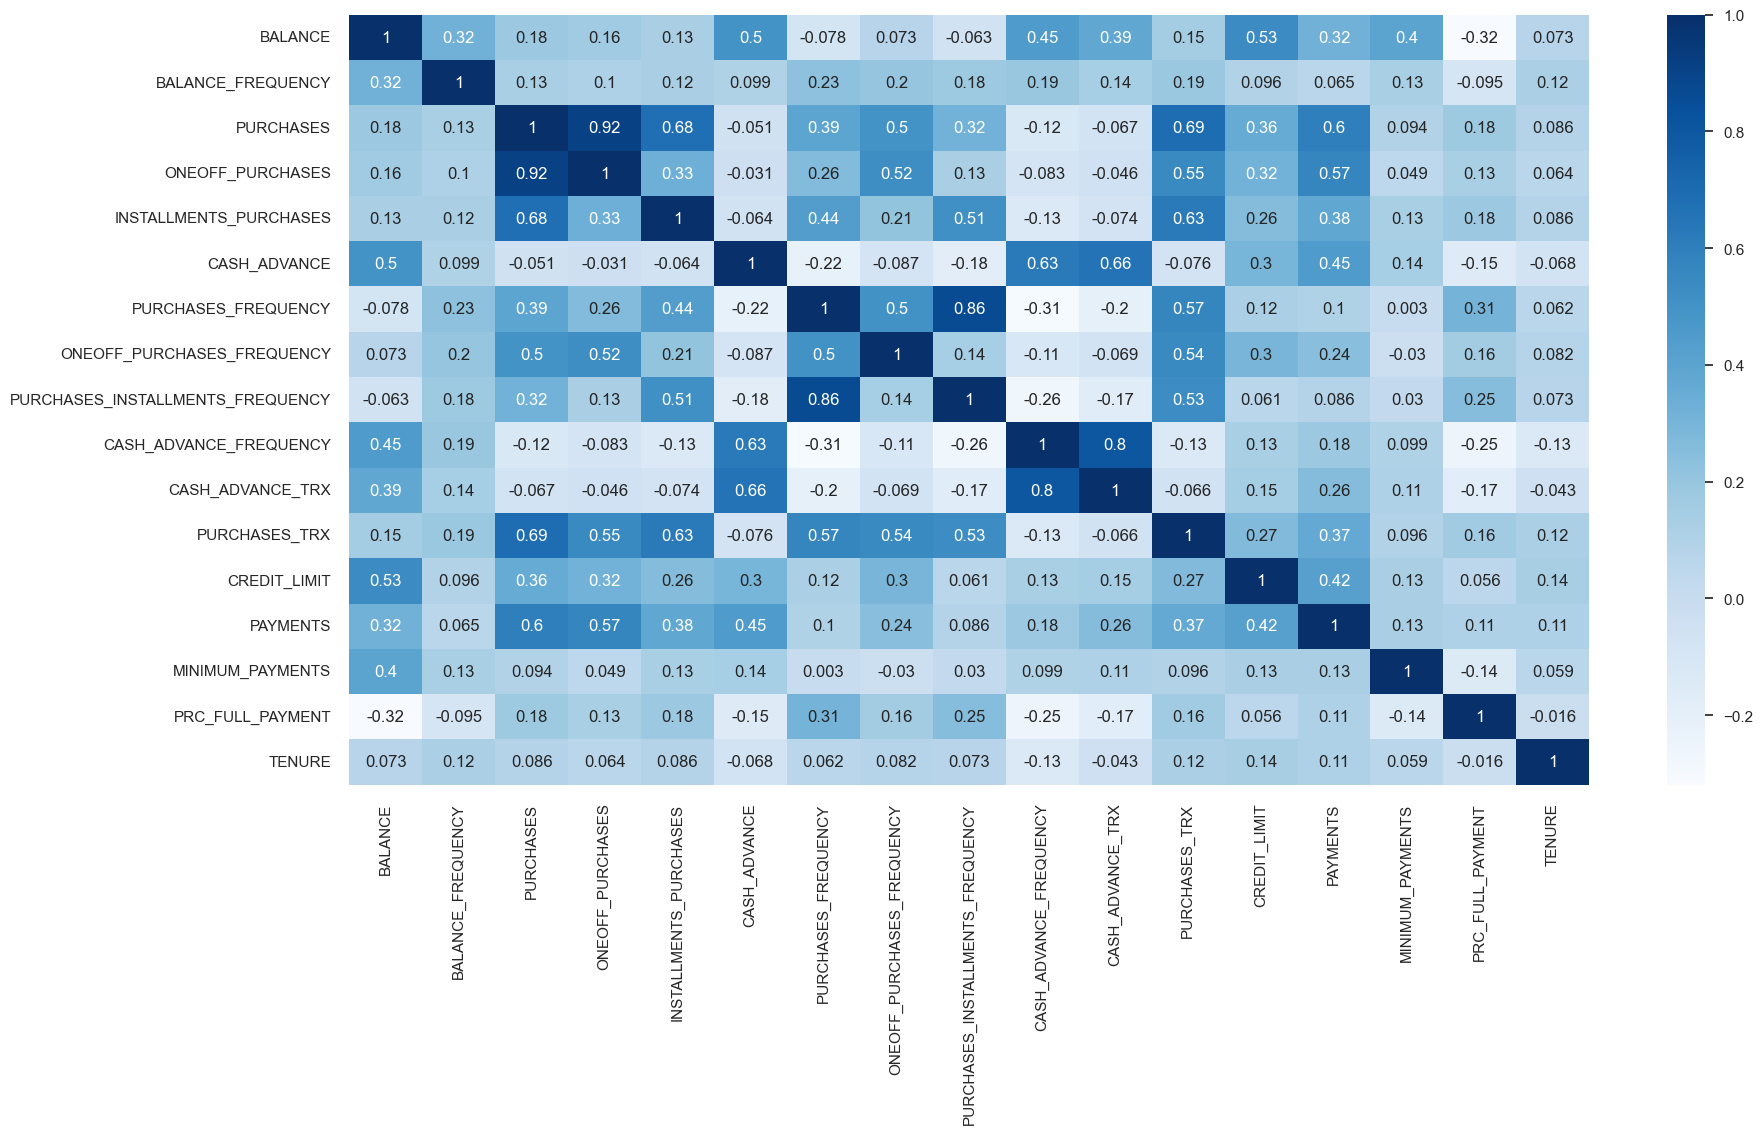

In [6]:
cor = creditcard_df.corr()
plt.figure(figsize=(20, 10))
sns.set(font_scale=1)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

In [7]:
corr_df = (creditcard_df.corr('spearman').round(2))
corr_df.style.background_gradient().set_precision(2)

/var/folders/b3/g26r0dcx4b35vf3nk31216hc0000gr/T/ipykernel_6151/2227010425.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = (creditcard_df.corr('spearman').round(2))
/var/folders/b3/g26r0dcx4b35vf3nk31216hc0000gr/T/ipykernel_6151/2227010425.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_df.style.background_gradient().set_precision(2)


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
BALANCE,1.00,0.54,0.01,0.15,-0.09,0.57,-0.15,0.12,-0.14,0.54,0.55,-0.05,0.37,0.43,0.90,-0.48,0.07
BALANCE_FREQUENCY,0.54,1.00,0.15,0.13,0.13,0.14,0.20,0.16,0.15,0.18,0.18,0.20,0.11,0.21,0.50,-0.17,0.23
PURCHASES,0.01,0.15,1.00,0.75,0.71,-0.38,0.79,0.69,0.61,-0.39,-0.38,0.89,0.26,0.39,-0.01,0.24,0.13
ONEOFF_PURCHASES,0.15,0.13,0.75,1.00,0.20,-0.18,0.42,0.95,0.12,-0.18,-0.18,0.59,0.30,0.36,0.07,0.05,0.10
INSTALLMENTS_PURCHASES,-0.09,0.13,0.71,0.20,1.00,-0.36,0.79,0.19,0.92,-0.37,-0.36,0.78,0.12,0.24,-0.05,0.28,0.12
CASH_ADVANCE,0.57,0.14,-0.38,-0.18,-0.36,1.00,-0.45,-0.19,-0.38,0.94,0.95,-0.41,0.16,0.26,0.48,-0.27,-0.11
PURCHASES_FREQUENCY,-0.15,0.20,0.79,0.42,0.79,-0.45,1.00,0.46,0.85,-0.45,-0.45,0.92,0.10,0.17,-0.10,0.29,0.10
ONEOFF_PURCHASES_FREQUENCY,0.12,0.16,0.69,0.95,0.19,-0.19,0.46,1.00,0.11,-0.18,-0.17,0.61,0.28,0.32,0.05,0.06,0.08
PURCHASES_INSTALLMENTS_FREQUENCY,-0.14,0.15,0.61,0.12,0.92,-0.38,0.85,0.11,1.00,-0.38,-0.37,0.78,0.05,0.12,-0.08,0.26,0.11
CASH_ADVANCE_FREQUENCY,0.54,0.18,-0.39,-0.18,-0.37,0.94,-0.45,-0.18,-0.38,1.00,0.98,-0.41,0.09,0.20,0.46,-0.29,-0.13


### Feature types and preprocessing 

Let's identify different feature types and transformations 

In [8]:
creditcard_df.columns

Index(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE'],
      dtype='object')

In [9]:
drop_features = ["CUST_ID"]
numeric_features = list(set(creditcard_df.columns) - set(drop_features))

In [10]:
from sklearn.impute import SimpleImputer

numeric_transformer = make_pipeline(SimpleImputer(), StandardScaler())

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features), ("drop", drop_features)
)

In [11]:
transformed_df = pd.DataFrame(
    data=preprocessor.fit_transform(creditcard_df), columns=numeric_features
)

In [12]:
transformed_df

,CASH_ADVANCE,PURCHASES,INSTALLMENTS_PURCHASES,BALANCE,PURCHASES_FREQUENCY,PRC_FULL_PAYMENT,TENURE,ONEOFF_PURCHASES,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,BALANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY
0,-0.466786,-0.424900,-0.349079,-0.731989,-0.806490,-0.525551,0.360680,-0.356934,-0.678661,-0.511333,-0.960433,-0.528979,-3.109675e-01,-0.249434,-0.476070,-0.707313,-0.675349
1,2.605605,-0.469552,-0.454576,0.786961,-1.221758,0.234227,0.360680,-0.356934,-0.678661,-0.591796,0.688639,0.818642,8.931021e-02,0.134325,0.110074,-0.916995,0.573963
2,-0.466786,-0.107668,-0.454576,0.447135,1.269843,-0.525551,0.360680,0.108889,2.673451,-0.109020,0.826062,-0.383805,-1.016632e-01,0.518084,-0.476070,-0.916995,-0.675349
3,-0.368653,0.232058,-0.454576,0.049099,-1.014125,-0.525551,0.360680,0.546189,-0.399319,-0.551565,0.826062,-0.598688,4.878305e-17,-1.016953,-0.329534,-0.916995,-0.258913
4,-0.466786,-0.462063,-0.454576,-0.358775,-1.014125,-0.525551,0.360680,-0.347294,-0.399319,-0.551565,-0.905464,-0.364368,-2.657913e-01,0.518084,-0.476070,-0.916995,-0.675349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,-0.466786,-0.333293,-0.132643,-0.737950,1.269843,1.183951,-4.122768,-0.356934,-0.678661,-0.350408,-0.960433,-0.486217,-3.498541e-01,0.518084,-0.476070,1.179833,-0.675349
8946,-0.466786,-0.329136,-0.122823,-0.742423,1.269843,-0.525551,-4.122768,-0.356934,-0.678661,-0.350408,-0.960433,-0.503396,4.878305e-17,0.518084,-0.476070,1.179833,-0.675349
8947,-0.466786,-0.401965,-0.294893,-0.740398,0.854576,0.329200,-4.122768,-0.356934,-0.678661,-0.390639,-0.960433,-0.570615,-3.354655e-01,-0.185477,-0.476070,0.760469,-0.675349
8948,-0.449352,-0.469552,-0.454576,-0.745174,-1.221758,0.329200,-4.122768,-0.356934,-0.678661,-0.591796,-1.097856,-0.580536,-3.469065e-01,-0.185477,-0.182998,-0.916995,0.157527


Now that we have transformed the data, we are ready to run K-Means to cluster credit card customers. 

### Choosing `n_clusters`

- There is no definitive method to find the optimal number of clusters. 
- Let's try different approaches. 

### The Elbow method

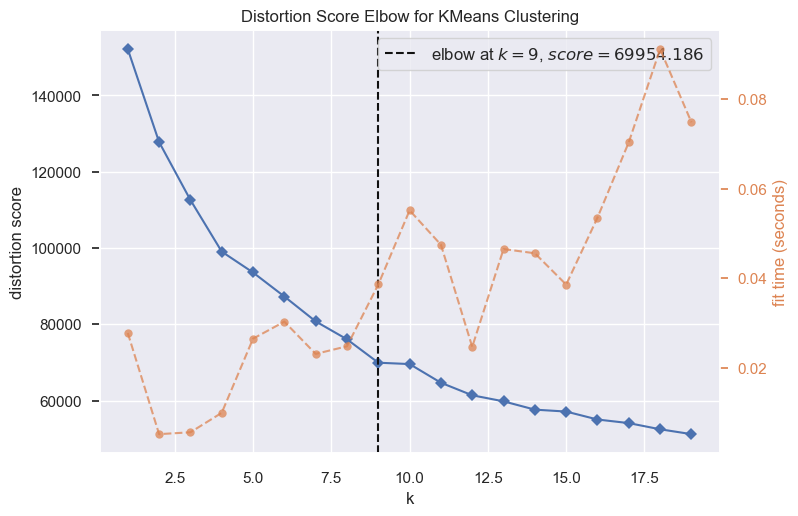

In [13]:
model = KMeans(random_state=42, n_init='auto')
visualizer = KElbowVisualizer(model, k=(1, 20))

visualizer.fit(transformed_df)  # Fit the data to the visualizer
visualizer.show();

- The optimal number of clusters is not as clear as it was in our toy example. 

- Let's examine Silhouette scores.  

/Users/kvarada/opt/miniconda3/envs/563/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


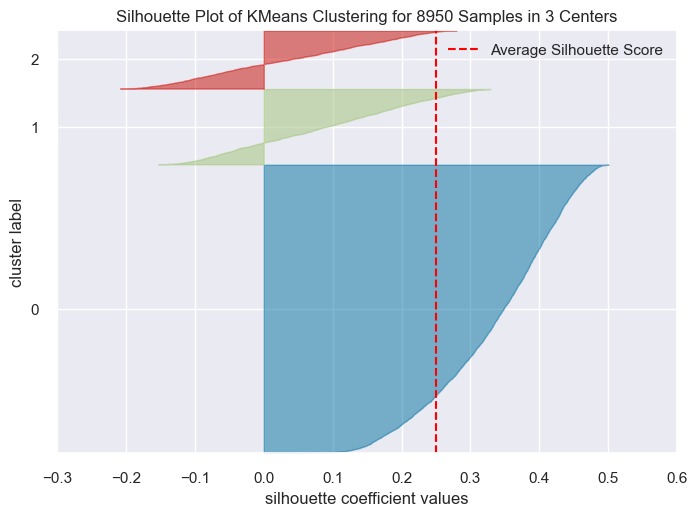

/Users/kvarada/opt/miniconda3/envs/563/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


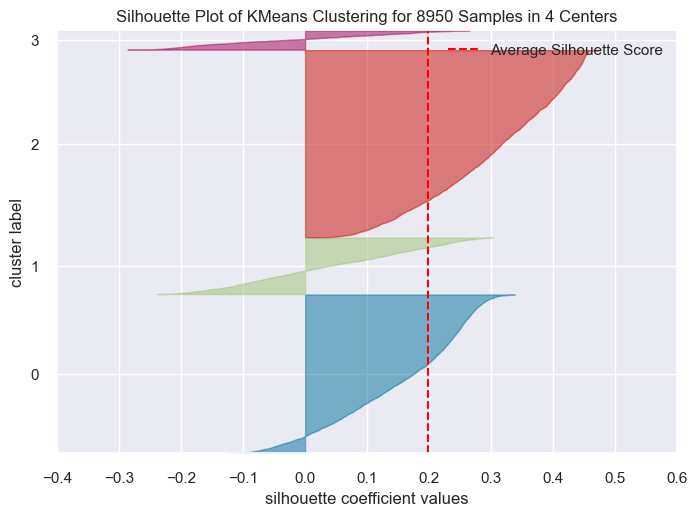

/Users/kvarada/opt/miniconda3/envs/563/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


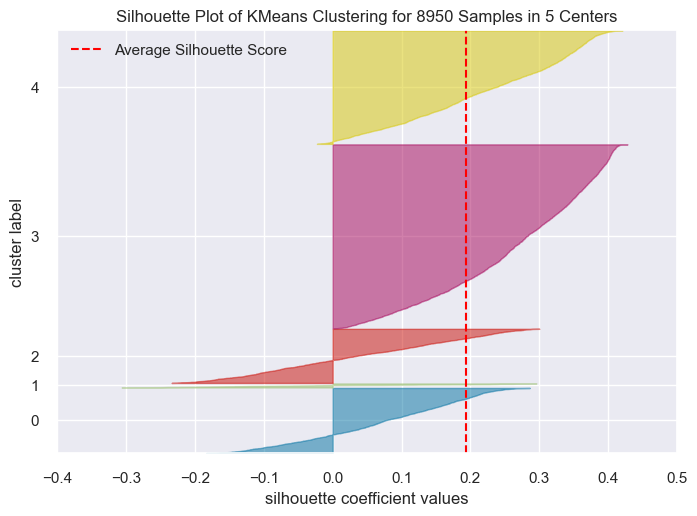

In [14]:
for k in range(3, 6):
    model = KMeans(k, random_state=42)
    visualizer = SilhouetteVisualizer(model, colors="yellowbrick")
    visualizer.fit(transformed_df)  # Fit the data to the visualizer
    visualizer.show()

- I'm going to run `KMeans` with `n_clusters = 4`. 
- You can try out `n_clusters = 5` and `n_clusters = 6` on your own. 

### Visualizing clusters 

- Can we visualize the clusters? 
- We have a high dimensional data and we need to reduce the dimensionality in order to visualize it. 
- Let's reduce the dimensionality using a technique called [UMAP](https://umap-learn.readthedocs.io/en/latest/index.html). 

I forgot to put this package in the course environment file. So to run the code below, you'll have to install the `umap-learn` package in the course conda environment either with `conda` or `pip`, as described in the [documentation](https://umap-learn.readthedocs.io/en/latest/index.html). 

```
> conda activate 563
> conda install -c conda-forge umap-learn
```

or 

```
> conda activate 563
> pip install umap-learn
```


In [15]:
import umap

In [16]:
def plot_umap_clusters(
    data,
    cluster_labels,
    size=50,
    n_neighbors=15,
    title="UMAP visualization",
):
    """
    Carry out dimensionality reduction using UMAP and plot 2-dimensional clusters.

    Parameters
    -----------
    data : numpy array
        data as a numpy array
    cluster_labels : list
        cluster labels for each row in the dataset
    size : int
        size of points in the scatterplot
    n_neighbors : int
        n_neighbors hyperparameter of UMAP. See the documentation.
    title : str
        title for the visualization plot

    Returns
    -----------
    None. Shows the clusters.
    """

    reducer = umap.UMAP(n_neighbors=n_neighbors)
    Z = reducer.fit_transform(data)  # reduce dimensionality
    umap_df = pd.DataFrame(data=Z, columns=["dim1", "dim2"])
    umap_df["cluster"] = cluster_labels

    labels = np.unique(umap_df["cluster"])

    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_title(title)

    scatter = ax.scatter(
        umap_df["dim1"],
        umap_df["dim2"],
        c=umap_df["cluster"],
        cmap="tab20b",
        s=size,
        edgecolors="k",
        linewidths=0.1,
    )

    legend = ax.legend(*scatter.legend_elements(), loc="best", title="Clusters")
    ax.add_artist(legend)

    plt.show()

/Users/kvarada/opt/miniconda3/envs/563/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


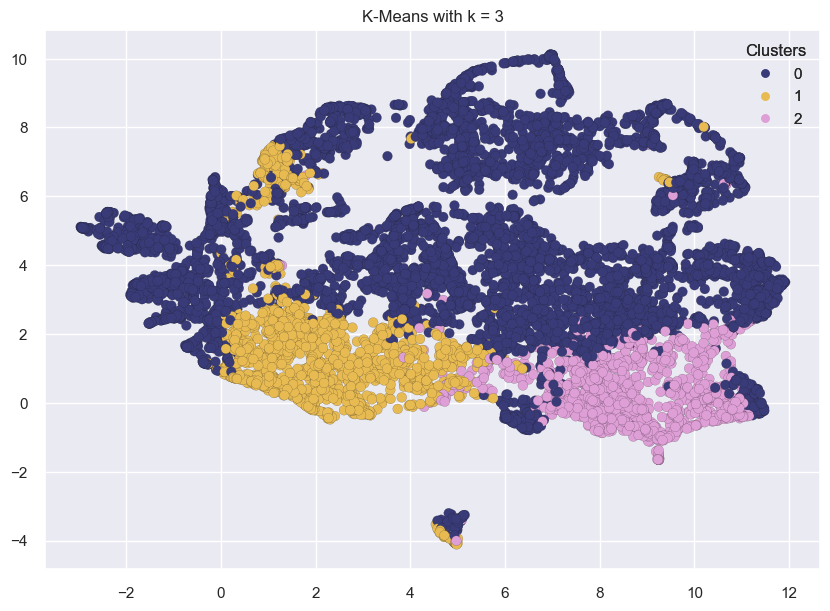

/Users/kvarada/opt/miniconda3/envs/563/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


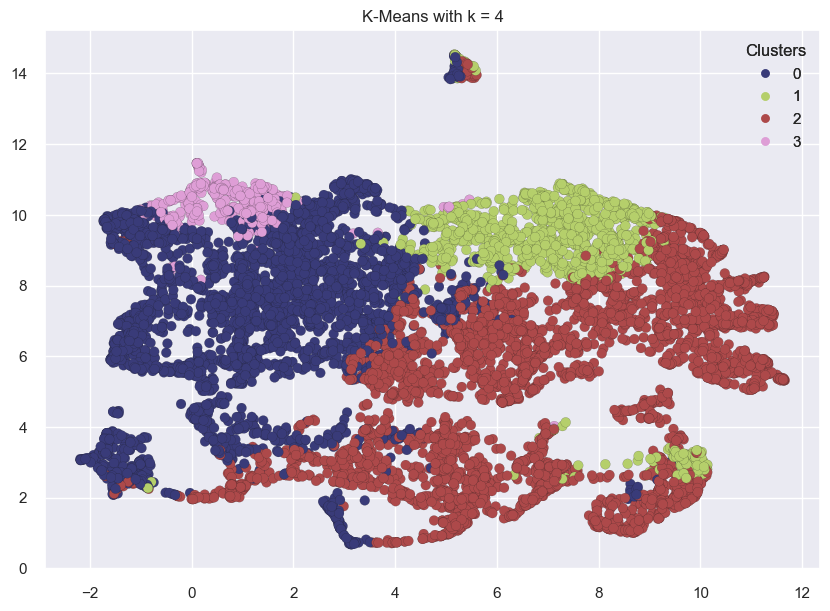

/Users/kvarada/opt/miniconda3/envs/563/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


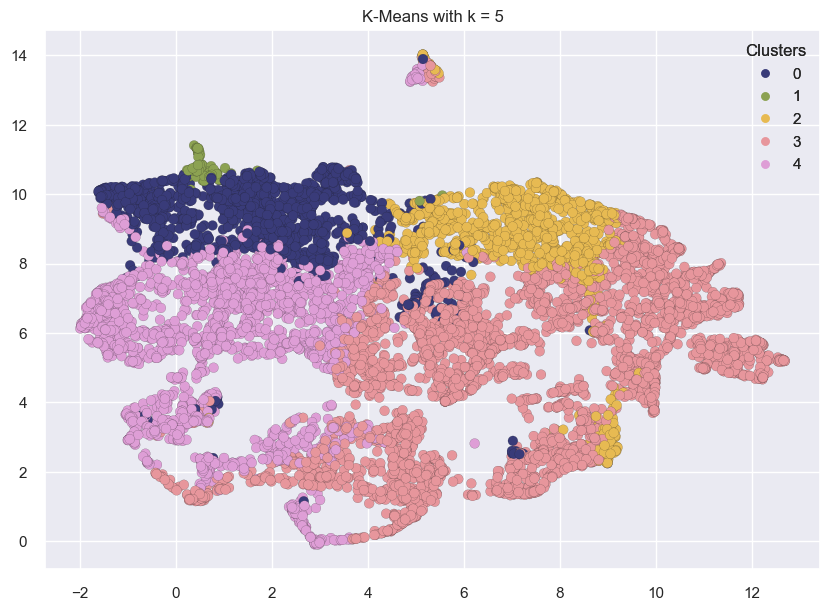

/Users/kvarada/opt/miniconda3/envs/563/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


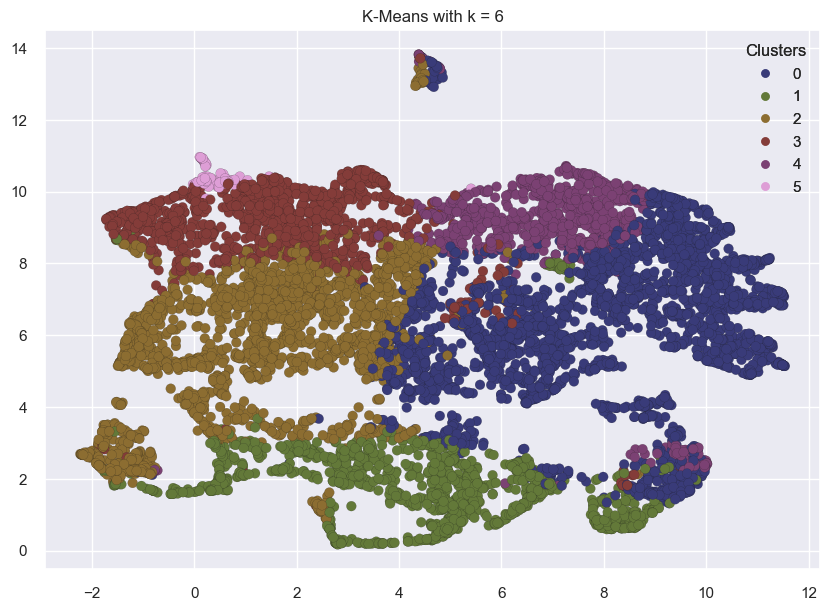

In [17]:
for k in range(3, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(transformed_df)
    labels = kmeans.labels_
    plot_umap_clusters(transformed_df, kmeans.labels_, title=f"K-Means with k = {k}")

- The clusters above look reasonably well separated. 
- This might not always be the case. 

### Cluster interpretation

- Let's examine the cluster centers for k=4 and identify types of customers.  

In [18]:
reasonable_k = 4
kmeans = KMeans(n_clusters=reasonable_k, random_state=42)
kmeans.fit(transformed_df)
labels = kmeans.labels_

/Users/kvarada/opt/miniconda3/envs/563/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [19]:
cluster_centers = pd.DataFrame(
    data=kmeans.cluster_centers_, columns=[transformed_df.columns]
)
cluster_centers

,CASH_ADVANCE,PURCHASES,INSTALLMENTS_PURCHASES,BALANCE,PURCHASES_FREQUENCY,PRC_FULL_PAYMENT,TENURE,ONEOFF_PURCHASES,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,BALANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY
0,-0.366373,0.109044,0.255904,-0.321688,0.983721,0.395041,0.057744,0.000926,0.317153,0.296985,-0.077298,-0.138502,-0.091844,0.242574,-0.360303,0.874138,-0.462599
1,1.688972,-0.234638,-0.253747,1.459578,-0.504848,-0.406367,-0.097146,-0.163914,-0.212939,-0.283580,0.838968,0.603821,0.490910,0.384753,1.617143,-0.450201,1.745948
2,-0.182691,-0.343190,-0.387798,-0.265552,-0.797823,-0.258866,-0.052972,-0.230500,-0.389437,-0.474987,-0.334417,-0.262060,-0.119249,-0.368944,-0.164607,-0.714246,-0.101500
3,-0.155091,3.125845,2.406470,0.954485,1.136338,0.454703,0.324140,2.713251,1.798653,3.003251,1.429882,1.919096,0.477421,0.462694,-0.170458,1.065918,-0.319096


- Recall that we have applied imputation and scaling on the dataset. 
- But we would be able to interpret these clusters better if the centers are in the original scale. 
- So let's apply inverse transformations to get the cluster center values in the original scale. 

In [20]:
data = (
    preprocessor.named_transformers_["pipeline"]
    .named_steps["standardscaler"]
    .inverse_transform(cluster_centers[numeric_features])
)

In [21]:
org_cluster_centers = pd.DataFrame(data=data, columns=numeric_features)
org_cluster_centers = org_cluster_centers.reindex(
    sorted(org_cluster_centers.columns), axis=1
)
org_cluster_centers

,BALANCE,BALANCE_FREQUENCY,CASH_ADVANCE,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,CREDIT_LIMIT,INSTALLMENTS_PURCHASES,MINIMUM_PAYMENTS,ONEOFF_PURCHASES,ONEOFF_PURCHASES_FREQUENCY,PAYMENTS,PRC_FULL_PAYMENT,PURCHASES,PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,PURCHASES_TRX,TENURE
0,894.907458,0.934734,210.570626,0.042573,0.790021,4213.207678,642.478274,650.167072,593.974874,0.297070,1332.194205,0.269258,1236.178934,0.885165,0.711842,22.091773,11.594595
1,4602.462714,0.968415,4520.724309,0.484526,14.284641,7546.957050,181.607404,2008.251157,320.373681,0.138934,3481.145990,0.034859,501.896219,0.287731,0.185516,7.661102,11.387312
2,1011.751528,0.789871,595.759339,0.114833,2.125503,3277.703165,60.386625,586.301239,209.853863,0.086281,974.505090,0.078001,269.973466,0.170146,0.080578,2.903421,11.446429
3,3551.153761,0.986879,653.638891,0.071290,2.085575,9696.943765,2587.208264,1976.815179,5095.878826,0.739031,7288.739497,0.286707,7681.620098,0.946418,0.788060,89.359413,11.951100


In [22]:
cluster_labels = {0: "Transactors", 1: "Revolvers", 2: "Low activity", 3: "VIP/Prime"}
org_cluster_centers["cluster_labels"] = list(cluster_labels.values())

In [23]:
relevant_cols = [
    "cluster_labels",
    "BALANCE",
    "CREDIT_LIMIT",
    "PRC_FULL_PAYMENT",
    "PURCHASES_FREQUENCY",
    "CASH_ADVANCE",
    "CASH_ADVANCE_FREQUENCY",
    "CASH_ADVANCE_TRX",
]
org_cluster_centers[relevant_cols]

,cluster_labels,BALANCE,CREDIT_LIMIT,PRC_FULL_PAYMENT,PURCHASES_FREQUENCY,CASH_ADVANCE,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX
0,Transactors,894.907458,4213.207678,0.269258,0.885165,210.570626,0.042573,0.790021
1,Revolvers,4602.462714,7546.957050,0.034859,0.287731,4520.724309,0.484526,14.284641
2,Low activity,1011.751528,3277.703165,0.078001,0.170146,595.759339,0.114833,2.125503
3,VIP/Prime,3551.153761,9696.943765,0.286707,0.946418,653.638891,0.071290,2.085575


One way to interpret and label the clusters above is as follows. 

#### Transactors
- Credit card users who pay off their balance every month with least amount of interest charges. 
- They are careful with their money. 
- They have lowest balance and cash advance

#### Revolvers
- Credit card users who pay off only part of their monthly balance. They use credit card as a loan.  
- They have highest balance and cash advance, high cash advance frequency, low purchase frequency, high cash advance transactions, low percentage of full payment
- Their credit limit is also high. (Lucrative group for banks 😟.)

#### Low activity
- There is not much activity in the account. It has low balance and not many purchases. 
- Credit card users who have low credit limit.

#### VIP/Prime
- Credit card users who have high credit limit. 
- They have high one-off purchases frequency, high number of purchase transactions. 
- They have high balance but they also have higher percentage of full payment, similar to transactors
- Target for increase credit limit (and increase spending habits)

### More on interpretation of clusters

- In real life, you'll look through all features in detail before assigning meaning to clusters. 
- This is not that easy, especially when you have a large number of features and clusters. 
- One way to approach this would be visualizing the distribution of feature values for each cluster. 
- Some domain knowledge would definitely help at this stage.  

In [24]:
creditcard_df['cluster'] = labels

Let's check the cluster assignment for the customer who made the maximum cash advance transaction. 

In [25]:
creditcard_df[creditcard_df["CASH_ADVANCE"] == max_cash_advance] 

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
2159,C12226,10905.05381,1.0,431.93,133.5,298.43,47137.21176,0.583333,0.25,0.5,1.0,123,21,19600.0,39048.59762,5394.173671,0.0,12,1


In [26]:
def show_hists(df=creditcard_df, cols=["BALANCE", "CASH_ADVANCE"]):
    for i in cols:
        plt.figure(figsize=(35, 5))
        for j in range(4):
            plt.subplot(1, 4, j + 1)
            cluster = df[df["cluster"] == j]
            cluster[i].hist(bins=20)
            plt.title(f"{i}    \nCluster: {cluster_labels[j]} ")

        plt.show()

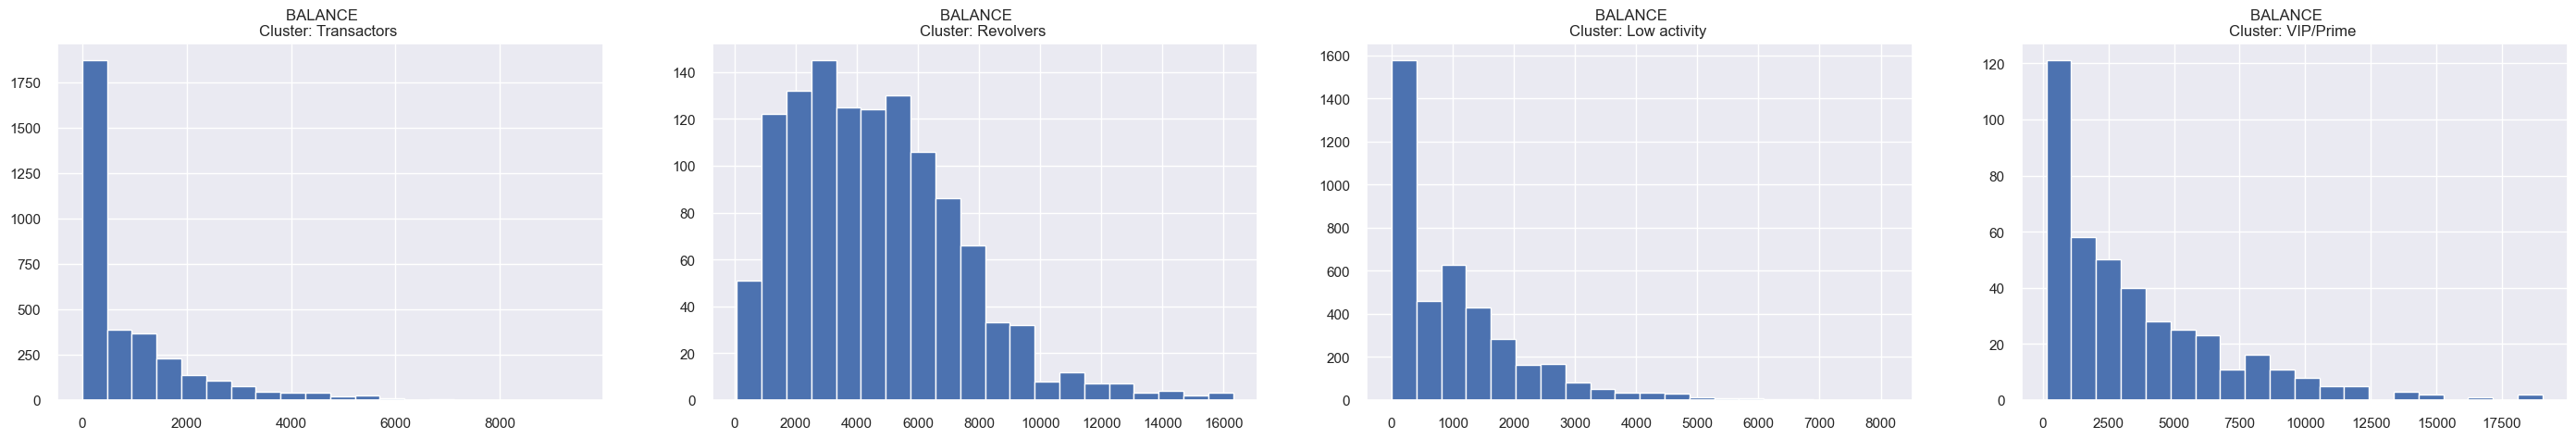

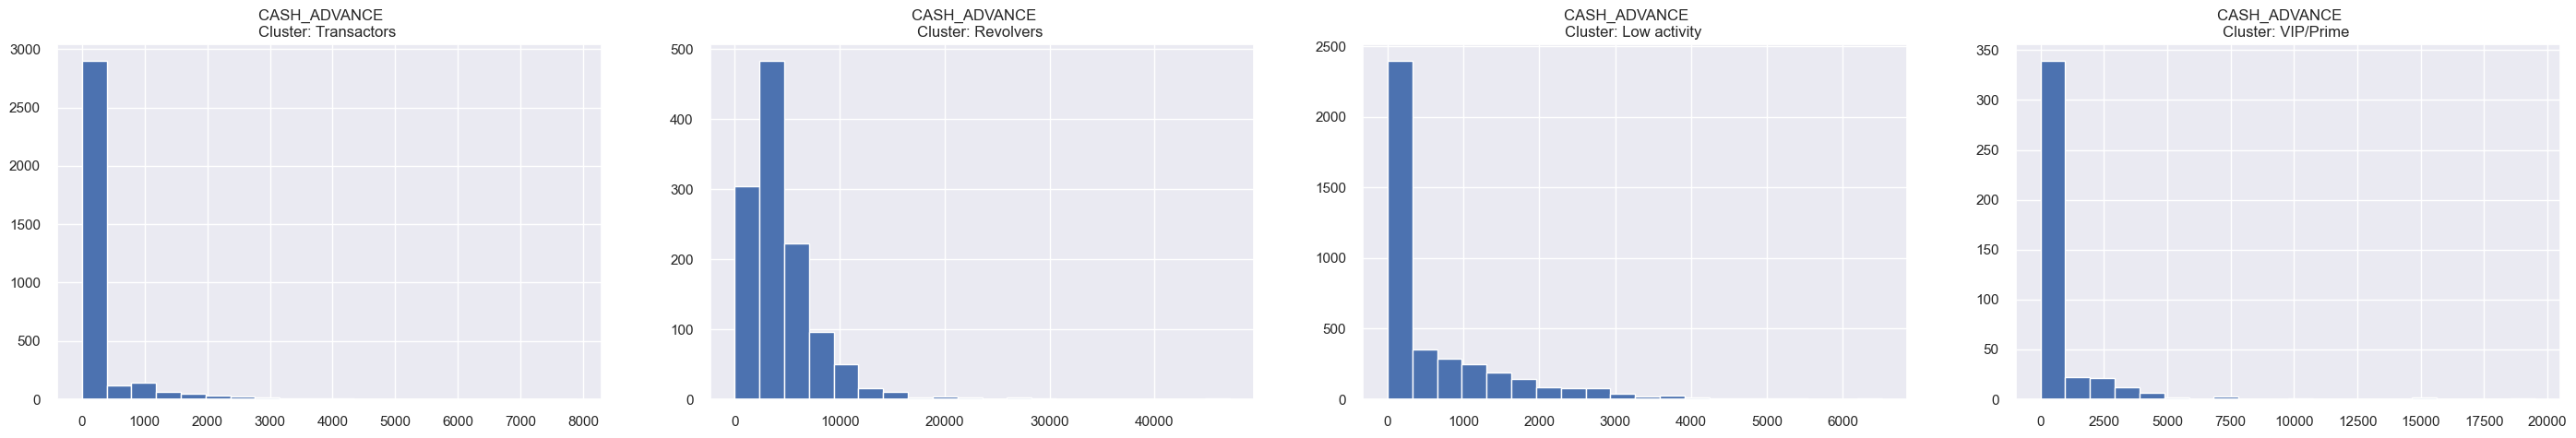

In [27]:
show_hists() # Examining clusters for two features. 

In [28]:
# Uncomment the code below to show histograms for all features. 
# cols = creditcard_df_cluster.columns.to_list()
# cols.remove('CUST_ID')
# cols.remove('cluster')
# show_hists(creditcard_df_cluster, cols)

### Practice exercise for you
- Try out different values for `n_clusters` in `KMeans` and examine the clusters. 
- If you are feeling adventurous, you may try customer segmentation on [All Lending Club loan data](https://www.kaggle.com/wordsforthewise/lending-club). 